In [14]:
import tensorflow as tf
import numpy as np
import pandas as pd
from PIL import Image
import sys
from tensorflow.keras.utils import to_categorical
import functools
!pip install mitdeeplearning
import mitdeeplearning as mdl
from tqdm import tqdm 
import matplotlib.pyplot as plt

In [ ]:
os.chdir(r"C:\Users\janan\OneDrive\Desktop\AI\AI Project\Final Project\diabetic-retinopathy-detection\models_build")


In [16]:
print(os.getcwd())


C:\Users\janan\OneDrive\Desktop\AI\AI Project\Final Project\diabetic-retinopathy-detection\Diabetic-Retinopathy-Detection-main\neural_nets


In [ ]:
get_ipython().run_line_magic('run', 'inception.ipynb')


In [ ]:
class TrainingDatasetLoader(object):
    def __init__(self,nb_classes):
        print ("Loading data into memory...")
        sys.stdout.flush()
        labels = pd.read_csv(r"C:\Users\janan\OneDrive\Desktop\AI\AI Project\Final Project\diabetic-retinopathy-detection\preprocessing\trainLabels_augmented.csv")
        self.y = np.array([1 if l >= 1 else 0 for l in labels['level']]) if (nb_classes == 2) else np.array([l for l in labels['level']])
        self.y = to_categorical(self.y, nb_classes)
        self.X_location = "C:/Users/janan/OneDrive/Desktop/AI/AI Project/Final Project/diabetic-retinopathy-detection/preprocessing/train_resized/resized-256/"
        self.size = self.y.shape[0]
        self.inds = np.random.permutation(np.arange(self.size))
        split = int(0.8*self.size) # 80:20 split
        self.X_train,self.X_val = self.inds[:split],self.inds[split:]
        self.lst_imgs = np.array([l for l in labels['train_image_name']])
        print("Done.")
        
    def get_train_size(self):
        return self.X_train.shape[0]
    
    def get_val_size(self):
        return self.X_val.shape[0]

    def get_train_steps_per_epoch(self, batch_size, factor=10):
        return self.get_train_size()//factor//batch_size

    def get_batch(self,n,src = 't', return_inds=False):
        choice = self.X_train if (src == 't') else self.X_val
        selected_inds = np.random.choice(choice, size=n, replace=False)
        sorted_inds = np.sort(selected_inds)
        img_names = self.lst_imgs[sorted_inds]
        label = self.y[sorted_inds]
        img = np.array([np.array(Image.open(self.X_location + img)) for img in img_names]).astype(np.float32)
        img /= 255.0
        return (img, label, sorted_inds) if return_inds else (img, label)


In [19]:
nb_classes = 2 #change output size
loader = TrainingDatasetLoader(nb_classes)
print('Training Size: '+ str(loader.get_train_size())+' images')
print('Validation Size: '+ str(loader.get_val_size())+' images')

Loading data into memory...
Done.
Training Size: 18638 images
Validation Size: 4660 images


In [20]:
IMG_SHAPE = (256, 256, 3) #change input shape

model = build_model(IMG_SHAPE,nb_classes)

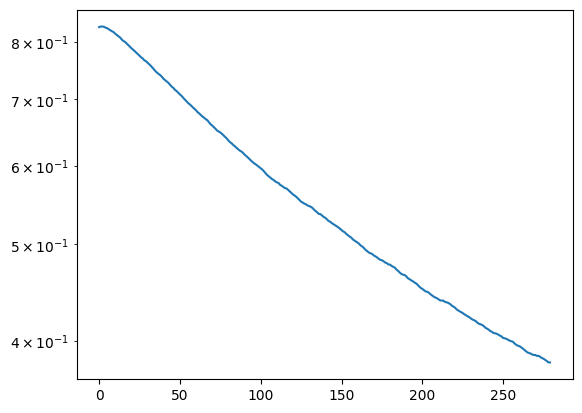

100%|██████████| 14/14 [02:13<00:00,  9.53s/it]


Training Accuracy: 0.866629481


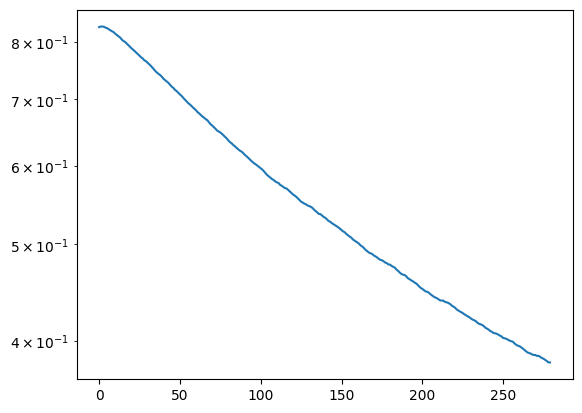

In [21]:
### Train the model ###

train_acc_results = []
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
val_acc_results = []
val_acc_metric = tf.keras.metrics.CategoricalAccuracy()
train_loss_results = []
train_loss_metric = tf.keras.metrics.BinaryCrossentropy()
val_loss_results = []
val_loss_metric = tf.keras.metrics.BinaryCrossentropy()

# Training hyperparameters
batch_size = 128
nb_epochs = 20
learning_rate = 0.0001
validation_steps_per_epoch = 50

optimizer = tf.keras.optimizers.Adam(learning_rate) # define our optimizer
loss_history = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
loss_fn = tf.keras.losses.BinaryCrossentropy()
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    # Feed the images into the model
    logits = model(x, training = True) 
    # Compute the loss
    loss = loss_fn(y_true=y, y_pred=logits)
  # Backpropagation
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  train_acc_metric.update_state(y,logits)
  train_loss_metric.update_state(y,logits)
  return loss

@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)
    val_loss_metric.update_state(y, val_logits)
  
for epoch in range(nb_epochs):
  # The training loop
  for idx in tqdm(range(loader.get_train_steps_per_epoch(batch_size, factor = 10))):
    # Grab a batch of training data and propagate through the network
    x, y = loader.get_batch(batch_size)
    loss = train_step(x, y)
    # Record the loss and plot the evolution of the loss as a function of training
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())

  train_acc_results.append(train_acc_metric.result())
  tf.print("\nTraining Accuracy:", train_acc_metric.result())
  train_acc_metric.reset_state()
  train_loss_results.append(train_loss_metric.result())
  train_loss_metric.reset_state()

  # The validation loop
  for i in range(validation_steps_per_epoch):
    x, y = loader.get_batch(batch_size,'v')
    test_step(x,y)

  val_acc_results.append(val_acc_metric.result())
  val_acc_metric.reset_state()
  val_loss_results.append(val_loss_metric.result())
  val_loss_metric.reset_state()

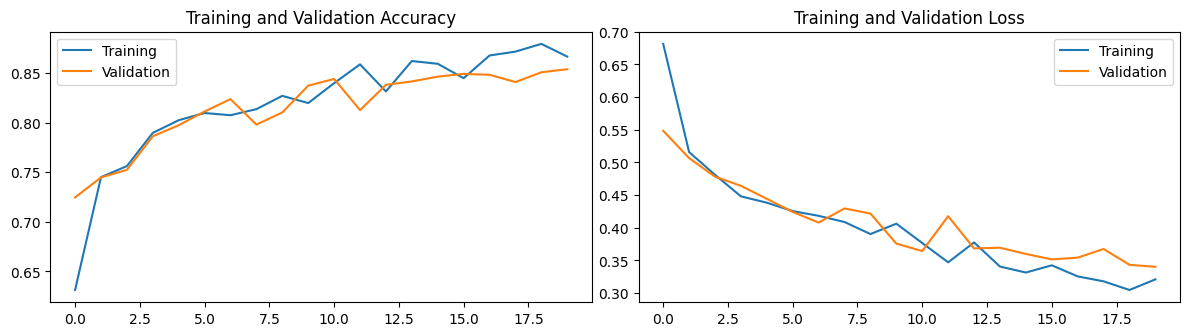

Training Accuracy: 0.866629481
Validation Accuracy: 0.853906274


In [22]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 10, forward=True)

ax[0].plot(train_acc_results)
ax[0].plot(val_acc_results)
ratio = 0.5
x_left, x_right = ax[0].get_xlim()
y_low, y_high = ax[0].get_ylim()
ax[0].set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend(["Training","Validation"])

ax[1].plot(train_loss_results)
ax[1].plot(val_loss_results)
ratio = 0.5
x_left, x_right = ax[1].get_xlim()
y_low, y_high = ax[1].get_ylim()
ax[1].set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax[1].legend(["Training","Validation"])
ax[1].set_title('Training and Validation Loss')


fig.tight_layout()
plt.show()

tf.print("Training Accuracy:",train_acc_results[-1])
tf.print("Validation Accuracy:",val_acc_results[-1])

In [23]:
### Unfreezing the top layers ###
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 172
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  311


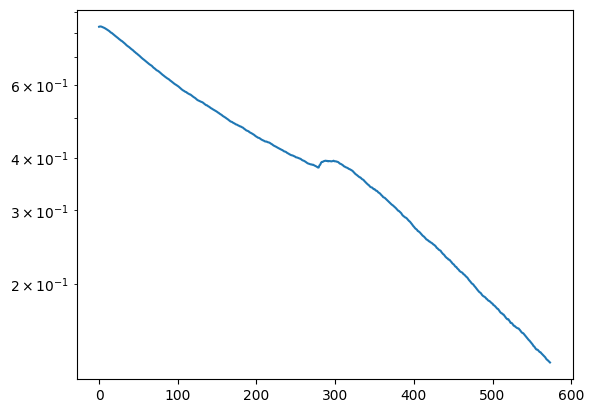

100%|██████████| 14/14 [02:28<00:00, 10.64s/it]


Training Accuracy: 0.975446403


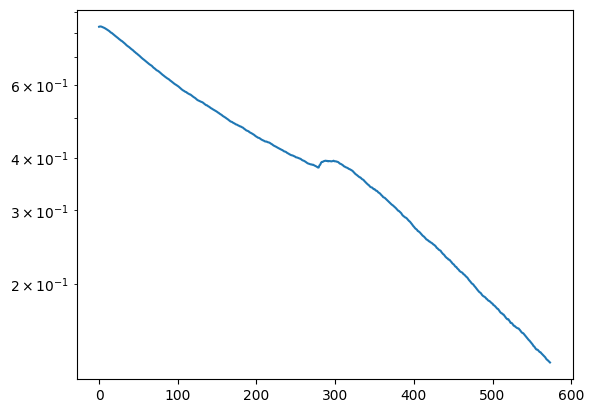

In [28]:
### Train the model ###

# Training hyperparameters
batch_size = 128
nb_epochs = 20
learning_rate = 0.00005
validation_steps_per_epoch = 50

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    # Feed the images into the model
    logits = model(x, training = True) 
    # Compute the loss
    loss = loss_fn(y_true=y, y_pred=logits)
  # Backpropagation
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  train_acc_metric.update_state(y,logits)
  train_loss_metric.update_state(y,logits)
  return loss

@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)
    val_loss_metric.update_state(y, val_logits)
  
for epoch in range(nb_epochs):
  optimizer = tf.keras.optimizers.Adam(learning_rate)
  # The training loop
  for idx in tqdm(range(loader.get_train_steps_per_epoch(batch_size, factor = 10))):
    # Grab a batch of training data and propagate through the network
    x, y = loader.get_batch(batch_size)
    loss = train_step(x, y)
    # Record the loss and plot the evolution of the loss as a function of training
    loss_history.append(loss.numpy().mean())
    plotter.plot(loss_history.get())

  train_acc_results.append(train_acc_metric.result())
  tf.print("\nTraining Accuracy:", train_acc_metric.result())
  train_acc_metric.reset_state()
  train_loss_results.append(train_loss_metric.result())
  train_loss_metric.reset_state()

  # The validation loop
  for i in range(validation_steps_per_epoch):
    x, y = loader.get_batch(batch_size,'v')
    test_step(x,y)

  val_acc_results.append(val_acc_metric.result())
  val_acc_metric.reset_state()
  val_loss_results.append(val_loss_metric.result())
  val_loss_metric.reset_state()

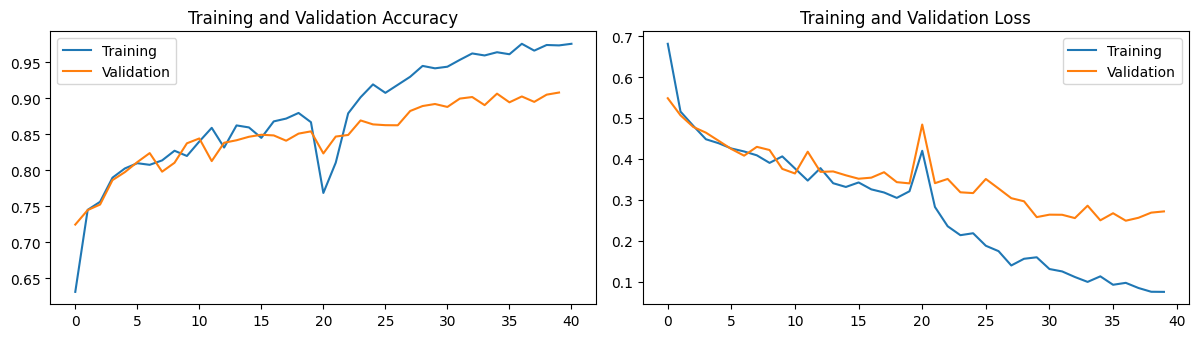

Training Accuracy: 0.975446403
Validation Accuracy: 0.907812476


In [29]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 10, forward=True)

ax[0].plot(train_acc_results)
ax[0].plot(val_acc_results)
ratio = 0.5
x_left, x_right = ax[0].get_xlim()
y_low, y_high = ax[0].get_ylim()
ax[0].set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend(["Training","Validation"])

ax[1].plot(train_loss_results)
ax[1].plot(val_loss_results)
ratio = 0.5
x_left, x_right = ax[1].get_xlim()
y_low, y_high = ax[1].get_ylim()
ax[1].set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax[1].legend(["Training","Validation"])
ax[1].set_title('Training and Validation Loss')


fig.tight_layout()
plt.show()

tf.print("Training Accuracy:",train_acc_results[-1])
tf.print("Validation Accuracy:",val_acc_results[-1])